# ADE20k

This notebook demonstrates how to compile the ADE20k dataset as a LITDataset.
Note that the paths and imports are based on paths in a local `localpaths.py` file, which are not part of the git repo.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pickle
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
import sys

In [3]:
# Import litdata from parent
sys.path.append('../')
from litdata.writer import LITWriter
from litdata.litdata import LITDataset

In [4]:
from localpaths import (
    ADE20K_ROOT, ADE20K_PFILE, LITDATAPATH,
    ADE20K_ROOT2TRAIN, ADE20K_ROOT2VAL, ADE20K_OBJECTINFO
)

In [5]:
root = ADE20K_ROOT
train = True
pfile = ADE20K_PFILE

In [6]:
with open(root + pfile, 'rb') as idxfile:
    _idxfile = pickle.load(idxfile)

# Overview

The indexfile has several keys.

- filename: Full list of all files in the dataset.
- folder: Folder of each image in the dataset.
- objectIsPart: An array of dimension (n_classes, n_samples) that states whether an object class acts as a part in each sample (?)
- objectPresence: An array of dimension (n_classes, n_samples) that states whether an object class is present in each sample.
- objectcounts: An array of shape (n_classes) which yields the total number of objects???? (Certain objects have 0????)
- objectnames: List of names for each class.
- proportionClassIsPart: Array of shape (n_classes), stating how often an object appears as a part in the samples.
- scene: List of len (n_samples) giving the general name of the scene class for each image. 
- wordnet_found: Array of shape (n_classes) indicating whether or not the object class is a wordnet class
- wordnet_level1: List of len (n_classes) yielding the first level hypernym in wordnet for each object class.
- wordnet_synset: List of len (n_classes) yielding the specific synset name for each object class.
- wordnet_hypernym: List of lists of len (n_classes) yielding all relevant hypernyms name for each object class.
- wordnet_gloss: List of len (n_classes) providing definitions and usage examples from WordNet for each object class, when applicable.
- wordnet_frequency: Array with shape less than (n_classes)? Obviously erroneous?
- description: A description of the indexfile.


## What to keep

- Input image, as jpg.
- Segmentation label, as seg16.
- Instance label, as seg8.
- Scene, as cls.
- Fileidx, as cls.
- objectPresence, as rle.

In [7]:
scenedict = {i:s for i, s in enumerate(sorted(list(set(_idxfile['scene']))))}
invscenedict = {s:i for i, s in enumerate(sorted(list(set(_idxfile['scene']))))}

In [8]:
validx = [((fol, fil), sce) for fol, fil, sce in zip(_idxfile['folder'], _idxfile['filename'], _idxfile['scene']) if 'validation' in fol]
trainidx = [((fol, fil), sce) for fol, fil, sce in zip(_idxfile['folder'], _idxfile['filename'], _idxfile['scene']) if 'training' in fol]
root2train = ADE20K_ROOT2TRAIN
root2val = ADE20K_ROOT2VAL

In [9]:
with open(ADE20K_OBJECTINFO, 'r') as infile:
    objectinfo = infile.read()

smallseglabels = []

for i, line in enumerate(objectinfo.split('\n')):
    if i == 0:
        smallseglabels.append('-')
    else:
        smallseglabels.append(line.split()[-1])

In [10]:
additional_metadata = {
    'website': 'https://groups.csail.mit.edu/vision/datasets/ADE20K/',
    'num_scene_classes': len(scenedict),
    'num_semantic_classes': len(_idxfile['objectnames']),
    'num_semantic_small_classes': len(smallseglabels),
}

In [11]:
def get_seg(filename, root=""):
    index = filename.index('.jpg')
    return Image.open(os.path.join(root, filename[:index] + '_seg.png'))

def split_seg(img):
    r,g,b = transforms.ToTensor()(img).mul(256).long().unbind(0)
    imcls = (r/10)*256 + g
    iminst = b.unique(return_inverse=True)[1]
    return imcls.long().numpy().astype(np.uint16), iminst.numpy().astype(np.uint8)

def get_objdict(fol, file, scene):    
    fname = os.path.join(root, fol, file)
    img = Image.open(fname)
    segimg = get_seg(fname)
    seg, inst = split_seg(segimg)
    scenelabel = invscenedict[scene]
    fileidx = _idxfile['filename'].index(file)
    keyname, ext = os.path.splitext(file)
    out = {
        '__key__': keyname,
        'jpg': img,
        'semantic.seg16': seg,
        'instance.seg8': inst,
        'scene.cls': scenelabel,
        'fileidx.cls': fileidx,
    }
    
    # Check if small segmentation label exists.
    istrain = 'training' in fol
    if istrain:
        altroot = root2train
    else:
        altroot = root2val
        
    # Get segmentation and resize
    smallpath = os.path.join(altroot, file[:-3] + 'png')
    if os.path.isfile(smallpath):
        smallseg = np.array(Image.open(smallpath).resize(segimg.size, Image.NEAREST))[...,0]
        out['semantic.small.seg8'] = smallseg
        
    return out

In [12]:
with LITWriter(
    'ADE20k', 
    LITDATAPATH, 
    additional_metadata=additional_metadata,
    groupname = 'DSB@UiO',
    shard_maxfiles = 5000,
) as litwriter:
    for i, ((fol, file), scene) in enumerate(trainidx):
        objdict = get_objdict(fol, file, scene)
        litwriter.train.write(objdict)
        if i % 250 == 0:
            display.clear_output(wait=True)
            print(f'train: {i:12d}/{len(trainidx):12d}')
            print(litwriter.train)
            

    for i, ((fol, file), scene) in enumerate(validx):
        objdict = get_objdict(fol, file, scene)
        litwriter.val.write(objdict)
        if i % 250 == 0:
            display.clear_output(wait=True)
            print(f'val:   {i:12d}/{len(validx):12d}')
            print(litwriter.val)


val:           1750/        2000
ShardWriter(
	Current Shard: /work2/litdata/ADE20k/val_0000.tar
	Current Shard Size: 0.27 GB
	Current Shard File Count: 1751
	Total File Count: 1751
)


In [13]:
dataset = LITDataset(
    'ADE20k', 
    LITDATAPATH, 
    override_extensions=['jpg', 'semantic.seg16', 'scene.cls', 'semantic.small.seg8'],
)

bedroom


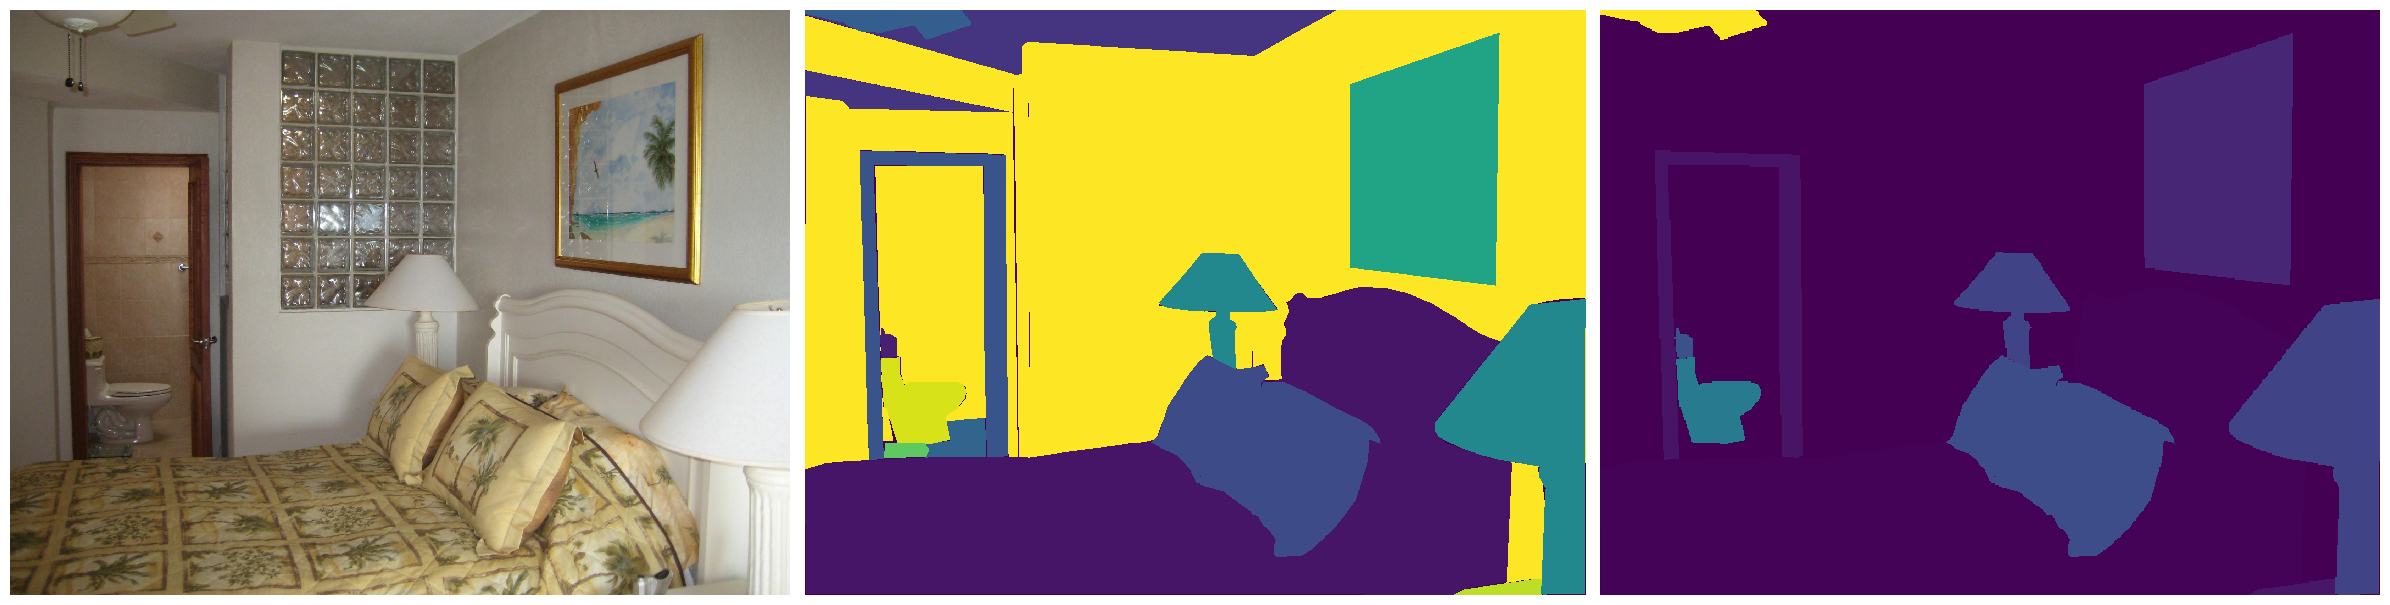

In [14]:
i = 2
fig, ax = plt.subplots(1,3,figsize=(24,8))
ax[0].matshow(np.array(dataset[i][0]))
ax[1].matshow(dataset[i][1])
ax[2].matshow(dataset[i][3])
print(scenedict[dataset[i][2]])
for a in ax.flatten():
    a.axis('off')
    
plt.tight_layout()

In [15]:
with open(os.path.join(LITDATAPATH, 'ADE20k/labeldict.semantic.json'), 'w') as outfile:
    json.dump(_idxfile['objectnames'], outfile)
    
with open(os.path.join(LITDATAPATH, 'ADE20k/labeldict.semantic.small.json'), 'w') as outfile:
    json.dump(smallseglabels, outfile)
    
with open(os.path.join(LITDATAPATH, 'ADE20k/labeldict.scene.json'), 'w') as outfile:
    json.dump([scenedict[i] for i in range(len(scenedict))], outfile)    
    
with open(os.path.join(LITDATAPATH, 'ADE20k/index_ade20k.pkl'), 'wb') as outfile:
    pickle.dump(_idxfile, outfile)

In [16]:
dataset

LITDataset(
    	fold=train,
	length=20210,
	use_extensions=('.jpg', '.semantic.seg16', '.scene.cls', '.semantic.small.seg8'),
	website = https://groups.csail.mit.edu/vision/datasets/ADE20K/,
	num_scene_classes = 1700,
	num_semantic_classes = 3688,
	num_semantic_small_classes = 151,
	num_train = 25574,
	num_val = 2000,
)